In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import random
import math
import scipy.io as sio
import h5py
import matplotlib as mpl
from cycler import cycler
import pickle

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
from utilities3 import *

# 3d fourier layers

In [ ]:

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])
        # Multiply relevant Fourier modes

        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width, inputsize, inputsize_vector):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.inputsize=inputsize
        self.inputsize_vector = inputsize_vector 
        # self.fc0 = nn.Linear(inputsize, self.width)
        self.fc0_ = nn.Parameter(torch.rand(inputsize_vector[1], inputsize_vector[2], inputsize_vector[3],\
                                            inputsize_vector[4],self.width, dtype=torch.float))


        # self.fc0_ = nn.Parameter(torch.rand( inputsize_vector[3], inputsize_vector[4],self.width, dtype=torch.float))
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 64)
        self.fc2 = nn.Linear(64, 1)

    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ixyzg->bixyg", input, weights)
        # return torch.einsum("bixyz,yzg->bixyg", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]

        # x = self.fc0(x)
        x =  self.compl_mul3d(x, self.fc0_)

        x = x.permute(0, 4, 1, 2, 3)
        x1 = self.conv0(x)
        x2 = self.w0(x.reshape(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.reshape(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2

        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x



# configs

In [ ]:
ntrain =800 # number of cases in the training set
ntest = 100
n_stressed_train = 10
n_stressed_test = 10

n_total=ntrain+ntest
# width = 20
batch_size_train = 100
batch_size = 100 # batchsize for testing


delta_t=0.01  # the time length between neighbouring time steps
sub_T = 3 # number of time steps between neighbouring point in the input tensor
T0=63 # the start of input data sequence
T_in = 60 # the time step included in the input data sequence, the length of input tensor is T_in/sub_T
T = 450 #the time step included in the output data sequence, the length of output tensor is T/sub_T

# the fault happens at 120
runtime = np.zeros(2, )


# Dataframe for training

## load data

load the training data generated by Power System Toolbox in MATLAB


The trajectory.mat file include trajectories from different initial point with different fault types


> For examples, if the total number of samples is 2000, the number of bus generators is 48, the simulated length is 10, the discretization time step is 0.01, then the trajectory.mat is a arrray of the shape (2000 * 7 * 48 * 1000)

> The dimension of 7 stand for the state variable






In [ ]:
# The dataset is generated by the simulation using Power System Toolbox.
# This dataset are trajectories under random fault, fault-clear time and fault-clear actions.
# The link to the dataset is https://drive.google.com/file/d/1SrQFbit6dPf0OhvFd4V8K64bOoNbB_CZ/view?usp=sharing

f = open("/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/2. TPS_revise/data/record220831_trajectory_NPCC_Fs12_Tieall_2000scale2.pckl", 'rb')
[Batch_delta_omaga_Time0] = pickle.load(f)
f.close()

############################
# This dataset are trajectories with stessed conditions
# We add this to the training and test set to reflet more about the prediction for stessed stable and unstable cases
# The link to the dataset is https://drive.google.com/file/d/1nDCAY0DIbsPWSmGA78ay9nM3hP4r6c1N/view?usp=sharing

f = open("/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/2. TPS_revise/data/record220831_trajectory_NPCC_Fs12_Tieall_90scale2_stressed.pckl", 'rb')
[Batch_delta_omaga_Time_stresses] = pickle.load(f)
f.close()

Great Britain transmission network

In [ ]:
# # For the Great Britain transmission network, run this block intead
# # The dataset is generated by ANDES (see https://docs.andes.app/en/latest/) 
# # The link to the dataset is https://drive.google.com/file/d/10Y_88SVfDcTNjz7Fet9auj22gd0VEHlE/view?usp=sharing

# f = open('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/2. TPS_revise/larger system/data/GB_record300T200_trajectory0906_train.pckl', 'rb')
# [Batch_delta_omaga_Time, Batch_Time_stamp] = pickle.load(f)

# f.close()

## data processing

In [ ]:
Batch_delta_omaga_Time_max = np.amax(np.amax(abs(Batch_delta_omaga_Time0[:,1,:,0:1000]),  axis=(-1)),  axis=(-1))
# Eliminate the case where the frequency deviation is unrealistically large
threshold_higher= 4
threshold_lower= 0.02
idx_select = np.where((Batch_delta_omaga_Time_max>threshold_lower)* (Batch_delta_omaga_Time_max<threshold_higher))
Batch_delta_omaga_Time = Batch_delta_omaga_Time0[idx_select]
np.shape(Batch_delta_omaga_Time)

In [ ]:
Batch_delta_omaga_Time = np.concatenate((Batch_delta_omaga_Time, Batch_delta_omaga_Time_stresses ), axis=0)
np.random.shuffle(Batch_delta_omaga_Time)

In [ ]:
np.shape(Batch_delta_omaga_Time)

In [ ]:
# The dimension of 7 stands for:
# row0: angle (rad)
# row1: frequency deviation （Hz）
# row2：active power
# row3: reactive power
# row4: voltage
# row5: type of fault - 0 three phase
#                     - 1 line to ground
#                     - 2 line-to-line to ground
#                     - 3 line-to-line
#                     - 4 loss of line with no fault
#                     - 5 loss of load at bus
# row6: idx of faulted line
idx_x_s=0
idx_x_e=48
idx_y_s=0
idx_y_e=7
full_idx_u=[0,1,4] # this is the index of variable to be predicted
dim_delta=idx_y_e-idx_y_s
dim_omega=idx_x_e-idx_x_s

# generate training data
train_a=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0:sub_T]).float()
train_u=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,full_idx_u,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
train_u_line=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,5:6,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
train_u_lineidx=torch.from_numpy(Batch_delta_omaga_Time[:ntrain,6:7,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()

n_test_start = 1000
# generate test data
test_a=torch.from_numpy(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0:sub_T]).float()
test_u=torch.from_numpy(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest,full_idx_u,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
test_u_line=torch.from_numpy(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest,5:6,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
test_u_lineidx=torch.from_numpy(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest,6:7,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()



print(np.shape(train_a))
print(np.shape(train_u))
print(np.shape(test_a))
print(np.shape(test_u))



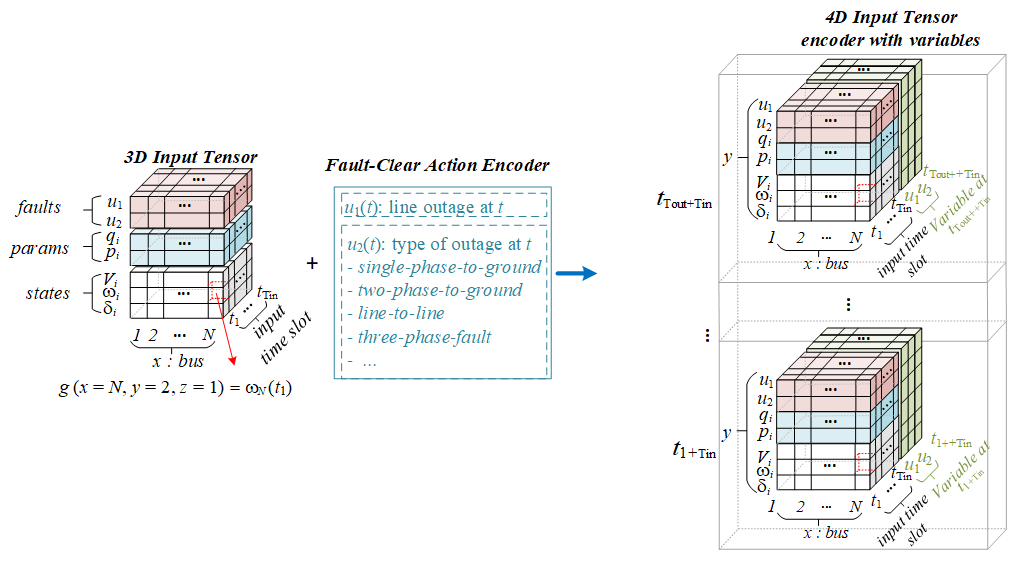

In [ ]:
# duplicate the input tensor on the dimension of output sequence
train_a = train_a.reshape(ntrain,dim_delta,dim_omega,1,int(T_in/sub_T)).repeat([1,1,1,int(T/sub_T),1])
train_u_line = train_u_line.reshape(ntrain,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
train_u_lineidx = train_u_lineidx.reshape(ntrain,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
# attach the future line fault and fault type information to be two addtional input
train_a = torch.cat((train_u_lineidx, train_u_line, train_a), dim=-1)


test_a = test_a.reshape(ntest,dim_delta,dim_omega,1,int(T_in/sub_T)).repeat([1,1,1,int(T/sub_T),1])
test_u_line = test_u_line.reshape(ntest,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
test_u_lineidx = test_u_lineidx.reshape(ntest,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
# attach the future line fault and fault type information to be two addtional input
test_a = torch.cat((test_u_lineidx, test_u_line, test_a), dim=-1)

print(np.shape(train_a))
print(np.shape(test_a))


In [ ]:
# batch normalization
a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)
y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

## pad locations (x,y,t)

In [ ]:

gridt = torch.tensor(delta_t*sub_T*np.arange(1,int(T/sub_T)+1), dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, int(T/sub_T), 1).repeat([1, dim_delta,dim_omega, 1, 1])

# attach the time stamp for the output sequence
train_a = torch.cat((gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)

print(gridt.size())
print(train_a.size())
print(test_a.size())

In [ ]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)
device = torch.device('cuda')

In [ ]:
print(train_a.size())
print(test_a.size())
print(train_u.size())
print(test_u.size())

# training and evaluation

In [ ]:
epochs =100
learning_rate = 0.025
scheduler_step = 100
scheduler_gamma = 0.85

modes1=3
modes2=3
modes3=6
width = 20
model = FNO3d(modes1, modes2, modes3, width,train_a.size()[-1],train_a.size()).cuda()

print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

record_mse=[]
record_train_l2=[]
record_test_l2=[]
myloss = LpLoss(size_average=False)
y_normalizer.cuda()
t1 = default_timer()

for ep in range(epochs):
    print('current memory allocated: {}'.format(torch.cuda.memory_allocated() / 1024 ** 2))
    print('max memory allocated: {}'.format(torch.cuda.max_memory_allocated() / 1024 ** 2))
    print('cached memory: {}'.format(torch.cuda.memory_cached() / 1024 ** 2))
    model.train()
    train_mse = 0
    train_l2 = 0
#     for x, y in train_loader:
    x, y = next(iter( train_loader))
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    out = model(x)[0:batch_size_train, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]

    mse = F.mse_loss(out, y, reduction='mean')
    y = y_normalizer.decode(y)
    out = y_normalizer.decode(out)
    l2 = myloss(out.view(batch_size_train, -1), y.view(batch_size_train, -1))
    l2.backward()

    optimizer.step()
    train_mse += mse.item()
    train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)[0:batch_size, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    print('episode',ep, '   train_mse', train_mse, '   train_l2', train_l2, '   test_l2', test_l2)

    record_mse.append(train_mse)
    record_train_l2.append(train_l2)
    record_test_l2.append(test_l2)
t2 = default_timer()

print('time', t2-t1)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator\
/2. TPS_revise/weights/stressed_NPCC0907_alltie_V7O3T3(63+60+450)_mode76_1230.pt')

In [ ]:
plt.plot(record_test_l2)

# Statistics

In [ ]:
# y_normalizer.cuda()


In [ ]:
test_l2 = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        print(x.size())

        out = model(x)[0:batch_size, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
        out = y_normalizer.decode(out)
        batch_mse = torch.sum(torch.square(out-y),dim=(1,2,3))
        y_square = torch.sum(torch.square(y),dim=(1,2,3))
        relative_mse = batch_mse/y_square

        batch_abs = torch.sum(torch.abs(out-y),dim=(1,2,3))
        y_abs = torch.sum(torch.abs(y),dim=(1,2,3))
        relative_abs = batch_abs/y_abs       
        # test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print('average mse error', torch.mean(relative_mse))
print('average abs error', torch.mean(relative_abs))


In [ ]:
# plt.hist(relative_mse.cpu().detach().numpy())
fig, ax = plt.subplots(1, 2, figsize=(10, 3)) 
# plt.subplots()
n, bins, patches = ax[0].hist(relative_abs.cpu().detach().numpy(), density=True,  bins=1000,  histtype='step',\
                           cumulative=True, label='Empirical')
ax[0].set_xlabel('relative abs error')
ax[0].set_ylabel('cdf')

n, bins, patches = ax[1].hist(relative_mse.cpu().detach().numpy(), density=True,  bins=1000,  histtype='step',\
                           cumulative=True, label='Empirical')
ax[1].set_xlabel('relative mse')
ax[1].set_ylabel('cdf')

In [ ]:
# plt.boxplot(relative_mse.cpu().detach().numpy())
quantile_precent = [0.7,0.8,0.9,0.95, 0.99]
quantile_mse = np.quantile(relative_mse.cpu().detach().numpy(), quantile_precent)
print('relative mse for quantile', quantile_precent, '\n', 'is', quantile_mse)

## plot performance

In [ ]:
sort_idx=np.argsort(relative_mse.cpu().detach().numpy())

In [ ]:
# randomly print 10 cases
plt.ion()
fig = plt.figure(figsize=(18,8), dpi=100)

for i in range(10):
    test_idx=random.randint(3, test_u.size()[0]-1)
    y = test_u[test_idx:test_idx+1]
    x = test_a[test_idx:test_idx+1]
    x = x.cuda()
    fault_info = test_a0[test_idx,5:7,0,22]
    # print('type of fault', fault_info[0], '      index of line fault', fault_info[1])
    fig=plt.figure(figsize=(11,5), dpi=100)
    fig.suptitle('Swing Dynamics  idx='+str(test_idx)+'  line'+str( fault_info[1]))

    TimeRecord=np.arange(0,y.size()[-1])*delta_t*sub_T
    plt.subplot(2,3,1)
    plt.plot(TimeRecord,torch.transpose(y[0,0,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('delta(rad)')
    plt.subplot(2,3,2)
    plt.plot(TimeRecord,torch.transpose(y[0,1,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')
    plt.subplot(2,3,3)
    plt.plot(TimeRecord,torch.transpose(y[0,2,:,:],0,1))
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')
    plt.subplot(2,3,4)
    out = model(x)[0:1, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
    out = y_normalizer.decode(out)
    plt.plot(TimeRecord,torch.transpose(out[0,0,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('delta(rad)')
    plt.subplot(2,3,5)
    plt.plot(TimeRecord,torch.transpose(out[0,1,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')
    plt.subplot(2,3,6)
    plt.plot(TimeRecord,torch.transpose(out[0,2,:,:],0,1).cpu().detach().numpy())
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.pause(0.01)
    plt.clf()




In [ ]:
# select all cases with frequency deviation larger than 2Hz to check prediction of unstable case
Batch_delta_omaga_Time_max_last = np.amax(abs(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest:,1,:,T0+T_in+T]),  axis=(-1))

threshold_higher= 0.5
idx_select_unstable = np.where((Batch_delta_omaga_Time_max_last>threshold_higher))

# idx_select_unstable = np.where((Batch_delta_omaga_Time_max>threshold_higher))
idx_select_unstable[0]

# Type1 and Type2 error

In [ ]:
# type 1: unstable predicted to be stable
# type 2: stable predicted to be unstable

Batch_delta_omaga_Time_max_last = np.amax(abs(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest:,1,:,T0+T_in+T]),  axis=(-1))
threshold_higher = 0.2
mean_idx = -20 # If the mean frequency deciation in the last 20 steps is larger than 0.2, than the case is unstable
idx_select_unstable = np.where((Batch_delta_omaga_Time_max_last>threshold_higher))
idx_select_unstable[0]
x = test_a[idx_select_unstable[0]]
x = x.cuda()
out = model(x)[:, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
out = y_normalizer.decode(out)
out = out.cpu().detach().numpy()
predict_unstable = np.amax(np.mean(abs(out[:,1,:,mean_idx:-1]),axis=(-1)),  axis=(-1))>threshold_higher
print('predict unstable wrong', 1-sum(predict_unstable)/np.shape(idx_select_unstable[0]))

Batch_delta_omaga_Time_max_last = np.amax(abs(Batch_delta_omaga_Time[n_test_start:n_test_start+ntest:,1,:,T0+T_in+T]),  axis=(-1))
threshold_higher = 0.2
idx_select_stable = np.where((Batch_delta_omaga_Time_max_last<=threshold_higher))
x = test_a[idx_select_stable[0]]
x = x.cuda()
out = model(x)[:, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
out = y_normalizer.decode(out)
out = out.cpu().detach().numpy()
predict_stable = np.amax(np.mean(abs(out[:,1,:,mean_idx:-1]),axis=(-1)),  axis=(-1))<threshold_higher

print('predict stable wrong', 1-sum(predict_stable)/np.shape(idx_select_stable[0]))

# Plot for paper

### setup

In [ ]:
test_l2 = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        print(x.size())

        out = model(x)[0:batch_size, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
        out = y_normalizer.decode(out)
        batch_mse=torch.sum(torch.square(out-y),dim=(1,2,3))
        y_square=torch.sum(torch.square(y),dim=(1,2,3))
        relative_mse=batch_mse/y_square

        batch_abs=torch.sum(torch.abs(out-y),dim=(1,2,3))
        y_abs=torch.sum(torch.abs(y),dim=(1,2,3))
        relative_abs=batch_abs/y_abs       
print('average mse error', torch.mean(relative_mse))
print('average abs error', torch.mean(relative_abs))


In [ ]:
out = out.cpu().detach().numpy()
y= y.cpu().detach().numpy()

The training data has been scaled with \\
state_scale = 2*log2(state) if state>2 \\
Therefore, the following code recover to the original unit

In [ ]:
scale_state_idx = [0,1]
out[:,scale_state_idx,:,: ] = pow(2, out[:,scale_state_idx,:,: ]/2)*(out[:,scale_state_idx,:,: ]>2)+\
                              (out[:,scale_state_idx,:,: ])*(out[:,scale_state_idx,:,: ]<=2)
y[:,scale_state_idx,:,: ] = pow(2, y[:,scale_state_idx,:,: ]/2)*(y[:,scale_state_idx,:,: ]>2)+\
                              (y[:,scale_state_idx,:,: ])*(y[:,scale_state_idx,:,: ]<=2)

In [ ]:
# load the information of the power system for plot
# data formate can be found matpower link: 
data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/Real Case/NPCC/dataset/npcc_line.mat')
line = data['line']
line = np.asarray(line, dtype=np.float32)
data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/Real Case/NPCC/dataset/npcc_mac.mat')
mac_con = data['mac_con']
mac_con = np.asarray(mac_con, dtype=np.float32)

## plot selected stable case

In [ ]:
# test_idx =32
test_idx =32

test_a0=Batch_delta_omaga_Time[n_test_start:n_test_start+ntest:,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0+T:sub_T]
fault = test_a0[test_idx,6,0,:]
# fault = test_a0[11,6,:,:]
np.where(fault!=0) # the time step for the on-fault system

In [ ]:
fault_info = test_a0[test_idx,5:7,0,22]
print('type of fault', fault_info[0], '      index of line fault', fault_info[1])

In [ ]:
# fault bus
line[int(fault_info[1])-1][0:2]

In [ ]:
state_idx=1 # select envolope  from frequency deviation 
# test_idx = 97
idx_min=list(dict.fromkeys(np.argmin(y[test_idx,state_idx,:,:],0)))
print('idx_min',idx_min)

idx_max=list(dict.fromkeys(np.argmax(y[test_idx,state_idx,:,:],0)))
print('idx_max',idx_max)


In [ ]:
state_idx=0
idx_min=list(dict.fromkeys(np.argmin(y[test_idx,state_idx,:,:],0)))
print('idx_min',idx_min)

idx_max=list(dict.fromkeys(np.argmax(y[test_idx,state_idx,:,:],0)))
print('idx_max',idx_max)

In [ ]:

bus_select = [30, 15, 23, 0, 33,  20, 4,19,34, 26]

bus_select.sort()
bus_select_index = mac_con[bus_select,1].astype(int)

bus_select_legend = ['bus '+str(i) for i in bus_select_index ]
print(bus_select_index)
print(bus_select )

In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])

fig=plt.figure(figsize=(11,5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T
plt.subplot(2,3,1)
# fig, ax = plt.subplots()
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,0,:,:],0), np.min(y[test_idx,0,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx,0,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\delta(rad)$')
# plt.ylim([0,2.5])

plt.subplot(2,3,2)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,1,:,:],0), np.min(y[test_idx,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx,1,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\omega(Hz)$')
# plt.ylim([-0.52,0.6])

plt.subplot(2,3,3)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,2,:,:],0), np.min(y[test_idx,2,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx,2,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('V(p.u.)')
plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.02), ncol=2 )

plt.subplot(2,3,4)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,0,:,:],0), np.min(out[test_idx,0,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx,0,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\delta$(rad)')
# plt.ylim([0,2.5])

plt.subplot(2,3,5)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,1,:,:],0), np.min(out[test_idx,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx,1,bus_select,:].T)
# plt.ylim([-0.52,0.6])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.subplot(2,3,6)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,2,:,:],0), np.min(out[test_idx,2,:,:],0), color='grey', alpha=0.1)
lines = plt.plot(TimeRecord,out[test_idx,2,bus_select,:].T)# plt.xlabel('time(s)')
plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.02), ncol=2 )
plt.ylabel('V(p.u.)')
# fig.canvas.draw()
# # fig.canvas.flush_events()
# fig.legend( lines, bus_select, loc = (0.15, 0.9), ncol=10 )

plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.show()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/3. TPS_revise_v2\
/figure/stable_dyn.png', bbox_inches='tight', dpi=600)  


## frequency domain

In [ ]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 150
# sample spacing
Delta_t = delta_t*sub_T
x = np.linspace(0.0, N*Delta_t, N, endpoint=False)

xf = fftfreq(N, Delta_t)[:N//2]


In [ ]:
fft_y = 2.0 * np.abs(fft(y[test_idx,:,:,:])[:,:,0:N//2])

In [ ]:
fft_out = 2.0 * np.abs(fft(out[test_idx,:,:,:])[:,:,0:N//2])


In [ ]:
fft_y = np.fft.fft(y[test_idx,:,:,:])
fft_out = np.fft.fft(out[test_idx,:,:,:])


In [ ]:
freq = np.fft.fftfreq((y[test_idx,1,:,:]).shape[-1])

In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])
step_bound_lower = 0
step_bound_upper = 75
one_side_change = 2
fig=plt.figure(figsize=(11,5), dpi=100)
TimeRecord=xf
TimeRecord=(freq[step_bound_lower:step_bound_upper])*150/(delta_t*sub_T*150)
plt.subplot(2,3,1)
# fig, ax = plt.subplots()
# mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,0,:,:],0), np.min(y[test_idx,0,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord, one_side_change*fft_y[0,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\delta)$')
# plt.ylim([0,2.5])

plt.subplot(2,3,2)
# mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,1,:,:],0), np.min(y[test_idx,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_y[1,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\omega)$')
# plt.ylim([-0.52,0.6])

plt.subplot(2,3,3)
# mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,2,:,:],0), np.min(y[test_idx,2,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_y[2,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(V)$')
# plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.02), ncol=2 )

plt.subplot(2,3,4)
# mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,0,:,:],0), np.min(out[test_idx,0,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_out[0,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\delta)$')
# plt.ylim([0,2.5])

plt.subplot(2,3,5)
# mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,1,:,:],0), np.min(out[test_idx,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_out[1,bus_select,step_bound_lower:step_bound_upper].T)
# plt.ylim([-0.52,0.6])
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\omega)$')
plt.subplot(2,3,6)
# mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,2,:,:],0), np.min(out[test_idx,2,:,:],0), color='grey', alpha=0.1)
lines = plt.plot(TimeRecord,one_side_change*fft_out[2,bus_select,step_bound_lower:step_bound_upper].T)# plt.xlabel('time(s)')
# plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.02), ncol=2 )
plt.ylabel('$\mathcal{F}(V)$')
# fig.canvas.draw()
# # fig.canvas.flush_events()
# fig.legend( lines, bus_select, loc = (0.15, 0.9), ncol=10 )

plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.show()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/2. TPS_revise/figure/freq_stable_dyn.png', bbox_inches='tight', dpi=600)  


In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])
step_bound_lower = 0
step_bound_upper = int(150/2)
one_side_change = 2
fig=plt.figure(figsize=(11,5), dpi=100)
TimeRecord=xf
TimeRecord=(freq[step_bound_lower:step_bound_upper])*150/(delta_t*sub_T*150)
plt.subplot(2,3,1)
mpl.pyplot.fill_between(TimeRecord, np.max(fft_y[0,:,step_bound_lower:step_bound_upper],0),
                        np.min(fft_y[0,:,step_bound_lower:step_bound_upper],0), color='grey', alpha=0.1)
plt.plot(TimeRecord, one_side_change*fft_y[0,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\delta)$')
# plt.ylim([0,2.5])

plt.subplot(2,3,2)
mpl.pyplot.fill_between(TimeRecord, np.max(fft_y[1,:,step_bound_lower:step_bound_upper],0), 
                        np.min(fft_y[1,:,step_bound_lower:step_bound_upper],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_y[1,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\omega)$')

plt.subplot(2,3,3)
mpl.pyplot.fill_between(TimeRecord, np.max(fft_y[2,:,step_bound_lower:step_bound_upper],0), 
                        np.min(fft_y[2,:,step_bound_lower:step_bound_upper],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_y[2,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(V)$')
plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.32), ncol=2 )

plt.subplot(2,3,4)
mpl.pyplot.fill_between(TimeRecord, np.max(fft_out[0,:,step_bound_lower:step_bound_upper],0),
                        np.min(fft_out[0,:,step_bound_lower:step_bound_upper],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_out[0,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\delta)$')

plt.subplot(2,3,5)
mpl.pyplot.fill_between(TimeRecord, np.max(fft_out[1,:,step_bound_lower:step_bound_upper],0), 
                        np.min(fft_out[1,:,step_bound_lower:step_bound_upper],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,one_side_change*fft_out[1,bus_select,step_bound_lower:step_bound_upper].T)
plt.xlabel('Freq(Hz)')
plt.ylabel('$\mathcal{F}(\omega)$')
plt.subplot(2,3,6)
mpl.pyplot.fill_between(TimeRecord, np.max(fft_out[2,:,step_bound_lower:step_bound_upper],0), 
                        np.min(fft_out[2,:,step_bound_lower:step_bound_upper],0), color='grey', alpha=0.1)
lines = plt.plot(TimeRecord,one_side_change*fft_out[2,bus_select,step_bound_lower:step_bound_upper].T)# plt.xlabel('time(s)')
plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.32), ncol=2 )
plt.ylabel('$\mathcal{F}(V)$')

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator\
/2. TPS_revise/figure/freq_stable_dyn.png', bbox_inches='tight', dpi=600)  


# Plot stressed case

## setup

In [ ]:
ntest = np.shape(Batch_delta_omaga_Time_stresses)[0]

test_a_stresses=torch.from_numpy(Batch_delta_omaga_Time_stresses[:,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0:sub_T]).float()
test_u_stresses=torch.from_numpy(Batch_delta_omaga_Time_stresses[:,full_idx_u,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
test_u_line_stresses=torch.from_numpy(Batch_delta_omaga_Time_stresses[:,5:6,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()
test_u_lineidx_stresses=torch.from_numpy(Batch_delta_omaga_Time_stresses[:,6:7,idx_x_s:idx_x_e,T_in+T0:T+T_in+T0:sub_T]).float()


test_a_stresses = test_a_stresses.reshape(ntest,dim_delta,dim_omega,1,int(T_in/sub_T)).repeat([1,1,1,int(T/sub_T),1])
test_u_line_stresses = test_u_line_stresses.reshape(ntest,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
test_u_lineidx_stresses = test_u_lineidx_stresses.reshape(ntest,1,dim_omega,int(T/sub_T),1).repeat([1,dim_delta,1,1,1])
# attach the future line fault and fault type information to be two addtional input
test_a_stresses = torch.cat((test_u_lineidx_stresses, test_u_line_stresses, test_a_stresses), dim=-1)
test_a_stresses = a_normalizer.encode(test_a_stresses)
test_a_stresses = torch.cat((gridt.repeat([ntest,1,1,1,1]), test_a_stresses), dim=-1)
test_loader_stresses = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_stresses, test_u_stresses), batch_size=batch_size, shuffle=False)


In [ ]:
test_l2 = 0.0
with torch.no_grad():
    for x, y in test_loader_stresses:
        x, y = x.cuda(), y.cuda()
        print(x.size())

        out = model(x)[0:batch_size, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
        out = y_normalizer.decode(out)
        batch_mse = torch.sum(torch.square(out-y),dim=(1,2,3))
        y_square = torch.sum(torch.square(y),dim=(1,2,3))
        relative_mse = batch_mse/y_square

        batch_abs = torch.sum(torch.abs(out-y),dim=(1,2,3))
        y_abs = torch.sum(torch.abs(y),dim=(1,2,3))
        relative_abs = batch_abs/y_abs       
        # test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print('average mse error', torch.mean(relative_mse))
print('average abs error', torch.mean(relative_abs))


In [ ]:
out = out.cpu().detach().numpy()
y= y.cpu().detach().numpy()

The training data has been scaled with \\
state_scale = 2*log2(state) if state>2 \\
Therefore, the following code recover to the original unit

In [ ]:
scale_state_idx = [0,1]
out[:,scale_state_idx,:,: ] = pow(2, out[:,scale_state_idx,:,: ]/2)*(out[:,scale_state_idx,:,: ]>2)+\
                              (out[:,scale_state_idx,:,: ])*(out[:,scale_state_idx,:,: ]<=2)
y[:,scale_state_idx,:,: ] = pow(2, y[:,scale_state_idx,:,: ]/2)*(y[:,scale_state_idx,:,: ]>2)+\
                              (y[:,scale_state_idx,:,: ])*(y[:,scale_state_idx,:,: ]<=2)

In [ ]:
# load the information of the power system for plot
# data formate can be found matpower link: 
data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/Real Case/NPCC/dataset/npcc_line.mat')
line = data['line']
line = np.asarray(line, dtype=np.float32)
data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/Real Case/NPCC/dataset/npcc_mac.mat')
mac_con = data['mac_con']
mac_con = np.asarray(mac_con, dtype=np.float32)

## plot selected unstable case

In [ ]:
test_idx =54
test_a0=Batch_delta_omaga_Time_stresses[:,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0+T:sub_T]
fault = test_a0[test_idx,6,0,:]
# fault = test_a0[11,6,:,:]
np.where(fault!=0) # the time step for the on-fault system

In [ ]:
fault_info = test_a0[test_idx,5:7,0,22]
print('type of fault', fault_info[0], '      index of line fault', fault_info[1])

In [ ]:
# fault bus
line[int(fault_info[1])-1][0:2]

In [ ]:
state_idx=1 # select envolope  from frequency deviation 
idx_min=list(dict.fromkeys(np.argmin(y[test_idx,state_idx,:,:],0)))
print('idx_min',idx_min)

idx_max=list(dict.fromkeys(np.argmax(y[test_idx,state_idx,:,:],0)))
print('idx_max',idx_max)


In [ ]:

# bus_select = [38, 42, 29, 27, 45, 42, 29, 27, 28, 4,12]
bus_select = [42, 29, 27,  4, 7, 26, 8,   38,  12, 33]

bus_select.sort()
bus_select_index = mac_con[bus_select,1].astype(int)

bus_select_legend = ['bus '+str(i) for i in bus_select_index ]

In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])
end_time = 105
# end_time = np.shape(y)[-1]
fig=plt.figure(figsize=(11,5), dpi=100)
TimeRecord=np.arange(0,end_time )*delta_t*sub_T
plt.subplot(2,3,1)
# fig, ax = plt.subplots()
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,0,:,:end_time ],0), np.min(y[test_idx,0,:,:end_time ],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx,0,bus_select,:end_time ].T)
plt.xlabel('time(s)')
plt.ylabel('$\delta(rad)$')
plt.ylim([-2,4.2])

plt.subplot(2,3,2)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,1,:,:end_time ],0), np.min(y[test_idx,1,:,:end_time ],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx,1,bus_select,:end_time ].T)
plt.xlabel('time(s)')
plt.ylabel('$\omega(Hz)$')
plt.ylim([-0.7,0.7])
plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.02), ncol=2 )

plt.subplot(2,3,3)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx,2,:,:end_time ],0), np.min(y[test_idx,2,:,:end_time ],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx,2,bus_select,:end_time ].T)
plt.xlabel('time(s)')
plt.ylabel('V(p.u.)')

plt.subplot(2,3,4)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,0,:,:end_time ],0), np.min(out[test_idx,0,:,:end_time ],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx,0,bus_select,:end_time ].T)
plt.xlabel('time(s)')
plt.ylabel('$\delta$(rad)')
plt.ylim([-2,4.2])

plt.subplot(2,3,5)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,1,:,:end_time ],0), np.min(out[test_idx,1,:,:end_time ],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx,1,bus_select,:end_time ].T)
plt.ylim([-0.7,0.7])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.legend(bus_select_legend, prop={'size': 8.2}, loc = (0.3, 0.02), ncol=2 )

plt.subplot(2,3,6)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx,2,:,:end_time ],0), np.min(out[test_idx,2,:,:end_time ],0), color='grey', alpha=0.1)
lines = plt.plot(TimeRecord,out[test_idx,2,bus_select,:end_time ].T)# plt.xlabel('time(s)')
plt.ylabel('V(p.u.)')
# fig.canvas.draw()
# # fig.canvas.flush_events()
# fig.legend( lines, bus_select, loc = (0.15, 0.9), ncol=10 )

plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/1. fourier neural operator/2. TPS_revise/figure/unstable_dyn.png', bbox_inches='tight', dpi=600)  

# plt.savefig('/content/drive/MyDrive/fourier neural operator/figure/unstable_dyn.png', bbox_inches='tight', dpi=600)  


## plot three boundary case

#### setup

In [ ]:
test_idx = 54
test_idx_unstable =54
test_idx_stable = 88
test_a0=Batch_delta_omaga_Time_stresses[:,idx_y_s:idx_y_e,idx_x_s:idx_x_e,0+T0:T_in+T0+T:sub_T]
fault = test_a0[test_idx,6,0,:]
np.where(fault!=0) # the time step for the on-fault system

In [ ]:
fault_info = test_a0[test_idx,5:7,0,22]
print('type of fault', fault_info[0], '      index of line fault', fault_info[1])

In [ ]:
# fault bus
line[int(fault_info[1])-1][0:2]

In [ ]:
state_idx=1 # select envolope  from frequency deviation 
idx_min=list(dict.fromkeys(np.argmin(y[test_idx,state_idx,:,:],0)))
print('idx_min',idx_min)

idx_max=list(dict.fromkeys(np.argmax(y[test_idx,state_idx,:,:],0)))
# idx_max=list(dict.fromkeys(np.argmax(out[test_idx,state_idx,:,:],0)))

print('idx_max',idx_max)


In [ ]:

bus_select = [42, 29, 27,  4, 7, 26, 8,   38,  12, 33]

# bus_select_index = bus_select
bus_select.sort()
bus_select_index = mac_con[bus_select,1].astype(int)

bus_select_legend = ['bus '+str(i) for i in bus_select_index ]

#### combine

In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
ylim_high = 0.7
ylim_low =-0.7

fig=plt.figure(figsize=(3.5,5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T
plt.subplot(2,1,1)

mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_stable,1,:,:],0), np.min(out[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_stable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.title('stressed-stable', fontdict = {'fontsize' : 12})

plt.legend(bus_select_legend, prop={'size': 7.5}, loc = (0.3, 0.0), ncol=2 )


ylim_high = 1.4
ylim_low =-0.7
plt.subplot(2,1,2)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_unstable,1,:,:],0), np.min(out[test_idx_unstable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_unstable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.title('stressed-unstable', fontdict = {'fontsize' : 12})


plt.tight_layout()
plt.subplots_adjust(top=0.9)



In [ ]:
# mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
ylim_high = 0.67
ylim_low =-0.67

fig=plt.figure(figsize=(3.5,5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T
plt.subplot(2,1,1)

mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx_stable,1,:,:],0), np.min(out[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx_stable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.title('stressed-stable', fontdict = {'fontsize' : 12})



ylim_high = 1.4
ylim_low =-0.7
plt.subplot(2,1,2)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx_unstable,1,:,:],0), np.min(out[test_idx_unstable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx_unstable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.title('stressed-unstable', fontdict = {'fontsize' : 12})


plt.tight_layout()
plt.subplots_adjust(top=0.9)


#### stable

In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
ylim_high = 0.7
ylim_low =-0.7

fig=plt.figure(figsize=(3.5,5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T
plt.subplot(2,1,1)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_stable,1,:,:],0), np.min(y[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_stable,1,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\omega(Hz)$')
plt.ylim([ylim_low,ylim_high])
plt.title('accurate', fontdict = {'fontsize' : 12})


plt.subplot(2,1,2)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_stable,1,:,:],0), np.min(out[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_stable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.title('predict', fontdict = {'fontsize' : 12})

plt.legend(bus_select_legend, prop={'size': 7.5}, loc = (0.3, 0.0), ncol=2 )


plt.tight_layout()
plt.subplots_adjust(top=0.9)



In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
ylim_high = 0.7
ylim_low =-0.7

fig=plt.figure(figsize=(3.5,2.5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T


mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_stable,1,:,:],0), np.min(y[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_stable,1,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\omega(Hz)$')
plt.ylim([ylim_low,ylim_high])

plt.legend(bus_select_legend, prop={'size': 7.}, loc = (0.3, 0.0), ncol=2 )


plt.tight_layout()
plt.subplots_adjust(top=0.9)



In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
ylim_high = 0.68
ylim_low =-0.68

fig=plt.figure(figsize=(3.5,2.5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T


mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx_stable,1,:,:],0), np.min(out[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx_stable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')


plt.tight_layout()
plt.subplots_adjust(top=0.9)

 


#### unstable

In [ ]:
# mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
ylim_high = 1.4
ylim_low =-0.7

fig=plt.figure(figsize=(3.5,5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T

plt.subplot(2,1,1)
mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_unstable,1,:,:],0), np.min(y[test_idx_unstable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_unstable,1,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\omega(Hz)$')
plt.ylim([ylim_low,ylim_high])
plt.title('accurate', fontdict = {'fontsize' : 12})



plt.subplot(2,1,2)
mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx_unstable,1,:,:],0), np.min(out[test_idx_unstable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx_unstable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')
plt.title('predict', fontdict = {'fontsize' : 12})

plt.legend(bus_select_legend, prop={'size': 7.5}, loc = (0.01, 0.5), ncol=2 )


plt.tight_layout()
plt.subplots_adjust(top=0.9)



In [ ]:
# mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', '#8c564b', '#1f77b4','#7f7f7f', '#bcbd22', '#17becf'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
# ylim_high = 0.7
# ylim_low =-0.7

fig=plt.figure(figsize=(3.5,2.5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T


mpl.pyplot.fill_between(TimeRecord, np.max(y[test_idx_unstable,1,:,:],0), np.min(y[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,y[test_idx_unstable,1,bus_select,:].T)
plt.xlabel('time(s)')
plt.ylabel('$\omega(Hz)$')
plt.ylim([ylim_low,ylim_high])

plt.legend(bus_select_legend, prop={'size': 7.}, loc = (0.18, 0.52), ncol=2 )


plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.show()



In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=[ '#d62728', '#e377c2','#2ca02c','#ff7f0e',   '#9467bd', 
                                                '#8c564b', '#7f7f7f','#17becf', '#bcbd22', '#1f77b4'])
# ylim_high = 0.7
# ylim_low =-0.7

fig=plt.figure(figsize=(3.5,2.5), dpi=100)
TimeRecord=np.arange(0,np.shape(y)[-1])*delta_t*sub_T


mpl.pyplot.fill_between(TimeRecord, np.max(out[test_idx_unstable,1,:,:],0), np.min(out[test_idx_stable,1,:,:],0), color='grey', alpha=0.1)
plt.plot(TimeRecord,out[test_idx_unstable,1,bus_select,:].T)
plt.ylim([ylim_low,ylim_high])
plt.xlabel('time(s)')
plt.ylabel('$\omega$(Hz)')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.show()



# computational time

In [ ]:
num_time_calc=0
for test_idx in range(0, test_u.size()[0]):

    y=test_u[test_idx:test_idx+1]
    x=test_a[test_idx:test_idx+1]
    x=x.cuda()

    t1=default_timer()
    out = model(x)[0:1, full_idx_u, 0:dim_omega, 0:int(T/sub_T),0]
    
    out = y_normalizer.decode(out)
    t2=default_timer()
    num_time_calc+=t2-t1

print('time', num_time_calc/test_u.size()[0])